In [1]:
import warnings
warnings.filterwarnings('ignore')
import inspect
import logging
import os

import pandas as pd

from csrank.util import setup_logging
from experiments.util import lp_metric_dict
import numpy as np
from experiments.dbconnection import DBConnector

Using TensorFlow backend.


In [2]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'results.log')
setup_logging(log_path=log_path)
logger = logging.getLogger('ResultParsing')
datasets = ['synthetic_dc', 'mnist_dc', 'tag_genome_dc', "letor_dc", "sushi_dc"]

In [3]:
def get_letor_string(dp):
    y =  str(dp['year']) 
    n = str(dp['n_objects'])
    return "y_{}_n_{}".format(y,n)
def get_results_for_dataset(DATASET):
    config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
    learning_problem = "discrete_choice"
    results_table = 'results.{}'.format(learning_problem)
    schema = 'masterthesis'
    start = 3
    select_jobs = "SELECT learner_params, dataset_params, hp_ranges, {0}.job_id, dataset, learner, {3} from {0} INNER JOIN {1} ON {0}.job_id = {1}.job_id where {1}.dataset=\'{2}\'"
    self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)
    keys = list(lp_metric_dict[learning_problem].keys())
    keys[-1] = keys[-1].format(6)
    metrics = ', '.join([x for x in keys])
    #print(metrics)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format(self.schema)
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    data = []
    for job in self.cursor_db.fetchall():
        job = dict(job)
        n_hidden = job['hp_ranges'][job['learner']].get("n_hidden", [])
        if job['hp_ranges'][job['learner']].get("n_hidden_set_layers", None)==[1,8]:
            job['learner'] = job['learner']+'_shallow'
        elif n_hidden==[1,4] or n_hidden==[1,5]:
            job['learner'] = job['learner']+'_shallow'

        if job['learner_params'].get("add_zeroth_order_model", False):
            job['learner'] = job['learner']+'_zero'
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    
    self.init_connection()
    avail_jobs = "{}.avail_jobs".format("pymc3")
    select_st = select_jobs.format(results_table, avail_jobs, DATASET, metrics)
    #print(select_st)
    self.cursor_db.execute(select_st)
    for job in self.cursor_db.fetchall():
        job = dict(job)
        if "letor" in job['dataset']:
            job['dataset'] = get_letor_string(job['dataset_params'])
        elif "sushi" in job['dataset']:
            job['dataset'] =  job['dataset']
        else:
            job['dataset'] = job['dataset_params']['dataset_type']
        job['learner'] = job['learner'].upper()
        job['dataset'] = job['dataset'].upper()
        values = list(job.values())
        keys = list(job.keys())
        columns = keys[start:]
        vals = values[start:]
        data.append(vals)
    df_full = pd.DataFrame(data, columns=columns)
    df_full = df_full.sort_values('dataset')
    del df_full['job_id']
    columns = list(df_full.columns)
    return df_full, columns

In [4]:
df_full, columns = get_results_for_dataset(datasets[4])
print(columns)
#df_full['zeroonerankaccuracy'] = 1 - df_full['zeroonerankloss']

df_full.loc[df_full['learner'] == 'GENERALIZED_EXTREME_VALUE']
df_full.head()

['dataset', 'learner', 'categoricalaccuracy', 'categoricaltopk2', 'categoricaltopk3', 'categoricaltopk4', 'categoricaltopk5', 'categoricaltopk6']


,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,SUSHI_DC,FATE_DC,0.3210,0.4285,0.5475,0.6690,0.7120,0.8015
27,SUSHI_DC,MULTINOMIAL_LOGIT_MODEL,0.2625,0.3800,0.5035,0.5675,0.6680,0.7825
28,SUSHI_DC,NESTED_LOGIT_MODEL,0.2710,0.3795,0.4955,0.6025,0.6715,0.7320
29,SUSHI_DC,NESTED_LOGIT_MODEL,0.2705,0.3700,0.4885,0.5935,0.6615,0.7105
30,SUSHI_DC,GENERALIZED_EXTREME_VALUE,0.2830,0.3950,0.5100,0.6430,0.7135,0.7900


In [5]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return maxi, mini
def get_name(name):
    named = dict()
    named["NEAREST_NEIGHBOUR_MEDOID"] = "Nearest Neighbour"
    named["NEAREST_NEIGHBOUR"] = "Most Similar Movie"
    named["DISSIMILAR_NEAREST_NEIGHBOUR"] = "Most Dissimilar Movie"
    named["CRITIQUE_FIT_LESS"] = "Best Critique-Fit Movie d=-1"
    named["CRITIQUE_FIT_MORE"] = "Best Critique-Fit Movie d=+1"
    named["DISSIMILAR_CRITIQUE_LESS"] = "Impostor Critique-Fit Movie d=-1"
    named["DISSIMILAR_CRITIQUE_MORE"] = "Impostor Critique-Fit Movie d=+1"
    named["UNIQUE_MAX_OCCURRING"] = "Mode Least Angle"
    named["Y_2007_N_10"] = "MQ2007 10 Objects"
    named["Y_2007_N_5"] = "MQ2007 5 Objects"
    named["Y_2008_N_10"] = "MQ2008 10 Objects"
    named["Y_2008_N_5"] = "MQ2008 5 Objects"
    if name not in named.keys():
        named[name] = name.lower().title()
    return named[name]
def create_combined_dfs(DATASET):
    df_full, columns = get_results_for_dataset(DATASET)
    data = []
    dataf = []
    for dataset, dgroup in df_full.groupby(['dataset']):
        max_feta = -100
        max_fate = -100
        max_ranknet = -100
        feta_r = []
        fate_r = []
        ranknet_r = []
        for learner, group in dgroup.groupby(['learner']):
            one_row = [dataset, learner]
            std = group.std(axis=0).values
            mean = group.mean(axis=0).values
            if np.all(np.isnan(std)):
                one_row.extend(["{:.4f}".format(m) for m in mean])
                #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
            else:
                #std = [s*1e3 for s in std]
                one_row.extend(mean)
                #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
            if "FETA" in str(learner):
                if max_feta < mean[0]-std[0]:
                    max_feta = mean[0]-std[0]
                    feta_r = one_row
                    feta_r[1] = "FETA_DC"
            elif "FATE" in str(learner):
                if max_feta < mean[0]-std[0]:
                    max_fate = mean[0]-std[0]
                    fate_r = one_row
                    fate_r[1] = "FATE_DC"
            elif "RANKNET" in str(learner):
                if max_ranknet < mean[0]-std[0]:
                    max_ranknet = mean[0]-std[0]
                    ranknet_r = one_row
                    ranknet_r[1] = "RANKNET_DC"
            else:
                data.append(one_row)
        data.append(feta_r)
        data.append(ranknet_r)
        data.append(fate_r)
    df = pd.DataFrame(data, columns=columns)
    df.sort_values(by='dataset')
    del df['categoricaltopk6']
    return df
DATASET = datasets[3]
df = create_combined_dfs(DATASET)
df.head()

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5
0,Y_2007_N_10,GENERALIZED_EXTREME_VALUE,0.29464,0.44872,0.56616,0.66660,0.75150
1,Y_2007_N_10,MIXED_LOGIT_MODEL,0.24628,0.38012,0.49158,0.58784,0.67918
2,Y_2007_N_10,MULTINOMIAL_LOGIT_MODEL,0.28682,0.44212,0.56622,0.66786,0.75254
3,Y_2007_N_10,NESTED_LOGIT_MODEL,0.30114,0.45762,0.57608,0.67656,0.75848
4,Y_2007_N_10,PAIRED_COMBINATORIAL_LOGIT,0.29040,0.44224,0.56350,0.66788,0.74982


In [16]:
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
def plot_group(grouped, plot_file, size, cols, a, b, maxi, mini):
    
    fig, axs = plt.subplots(a, b, figsize=size, sharey=True, frameon=True, edgecolor='k', facecolor='white')
    fig.subplots_adjust(hspace=0)
    
    for i, group in enumerate(grouped):
        name, group = group[0], group[1]
        if "N_5" in name:
            del group['categoricaltopk5']
        N_OBJECTS_ARRAY = np.arange(len(group.columns[2:])) + 1
        dataFrame = group.set_index('learner').T
        try:
            sub_plot = axs[i]
        except Exception:
            sub_plot = axs
        for learner, model in zip(Dlower,models):
            if learner in list(dataFrame.columns):
                acc = dataFrame[learner].as_matrix()[1:]
                sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker="o")
        sub_plot.set_yticks(np.arange(mini,maxi+0.1,0.05))
        sub_plot.set_xticks(N_OBJECTS_ARRAY)
        sub_plot.set_xlabel(x_label)
        if i == 0:
            sub_plot.set_ylabel(y_label)
        title = "{} {}".format(anotation[i],get_name(name))
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
                #maxi, mini = get_max_min(maxi, mini, acc)
    plt.xticks(N_OBJECTS_ARRAY)
    plt.legend(ncol=cols, fancybox=False, shadow=False, frameon=True, facecolor='white',framealpha=0.1, edgecolor='k')
    plt.savefig(plot_file, facecolor='w', edgecolor='w',transparent=False, dpi=800,format='pdf',bbox_inches = 'tight', pad_inches = 0)
    plt.tight_layout()
    plt.show()
def plot_graphs_for_dataset(DATASET):
    plot_file = os.path.join(DIR_PATH, 'thesis', "{}{}.pdf".format(DATASET.split('_dc')[0], '{}'))
    df = create_combined_dfs(DATASET)
    grouped = df.groupby(['dataset'])
    
    maxi = np.around(np.max(df.as_matrix()[:,2:]),2)
    mini = np.around(np.min(df.as_matrix()[:,2:]),2)
    i = 0
    if len(grouped)in [4,6]:
        a = 1
        b = 2
        size = (15,5)
    if len(grouped) == 3:
        a = 1
        b = 3
        size = (18,5)
    if len(grouped)==1:
        a = 1
        b = 1
        size = (8,5)
    ns = int(len(grouped)/b)

    if ns == 1:
        ns = len(grouped)
        plot_files = [plot_file.format('')]
    else:
        plot_files = [plot_file.format('_'+str(i)) for i in range(ns)]

    groups = np.array([group for group in grouped])
    dict_inds = {'synthetic_dc':  [[0,1,2]], 'mnist_dc': [[2,0], [3,1]], 'tag_genome_dc':[[0,1], [2,3], [4,5]], 
                 'letor_dc': [[2,0], [3,1]], 'sushi_dc':  [[0]]}
    #inds = 
    inds = dict_inds[DATASET]
    for i, plot_file in enumerate(plot_files):
        if i == 0:
            cols = 3
        else:
            cols = 3
        plot_group(groups[inds[i]], plot_file, size, cols, a, b, maxi, mini)

synthetic_dc


<IPython.core.display.Javascript object>


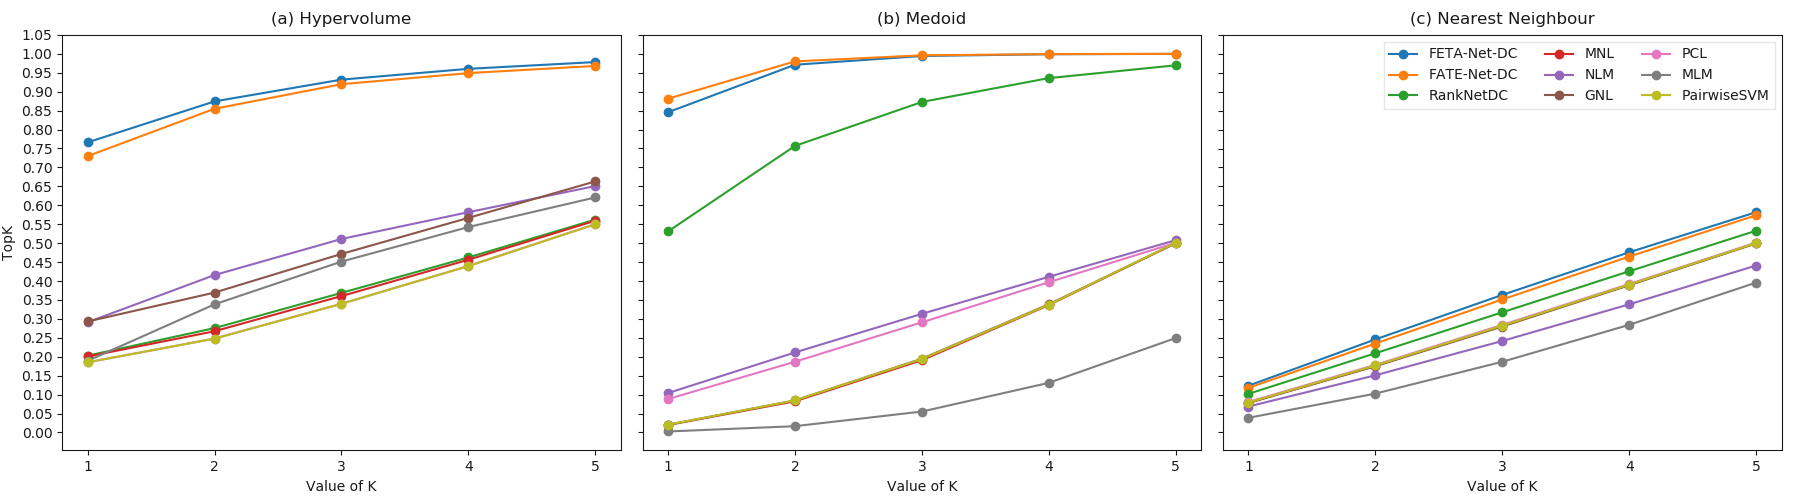

mnist_dc


<IPython.core.display.Javascript object>


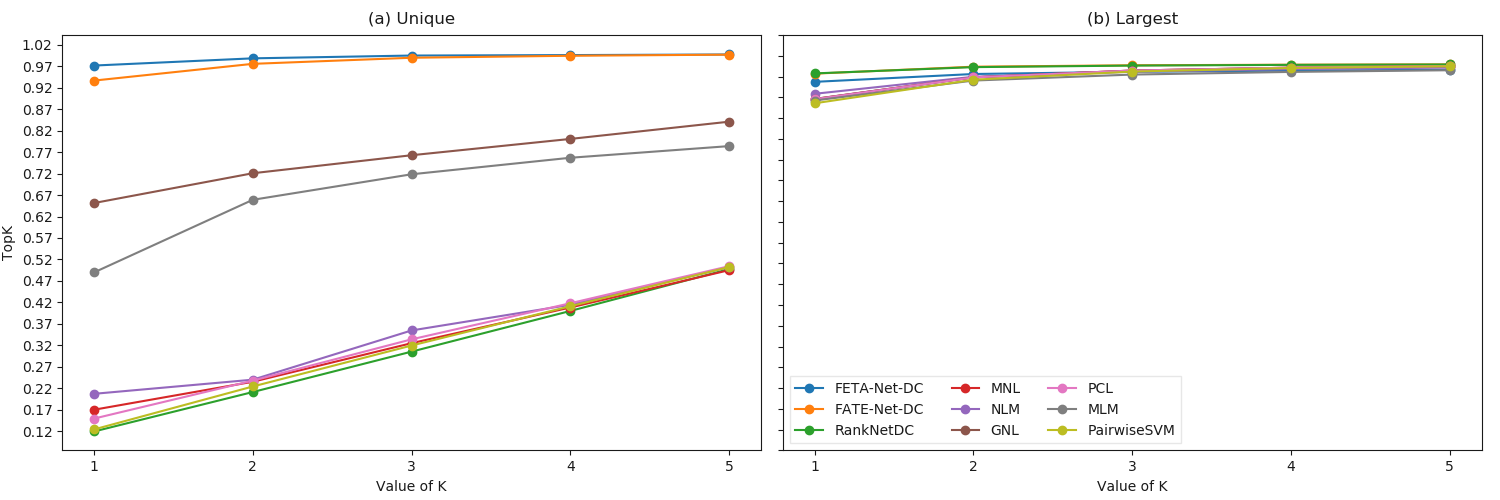

<IPython.core.display.Javascript object>


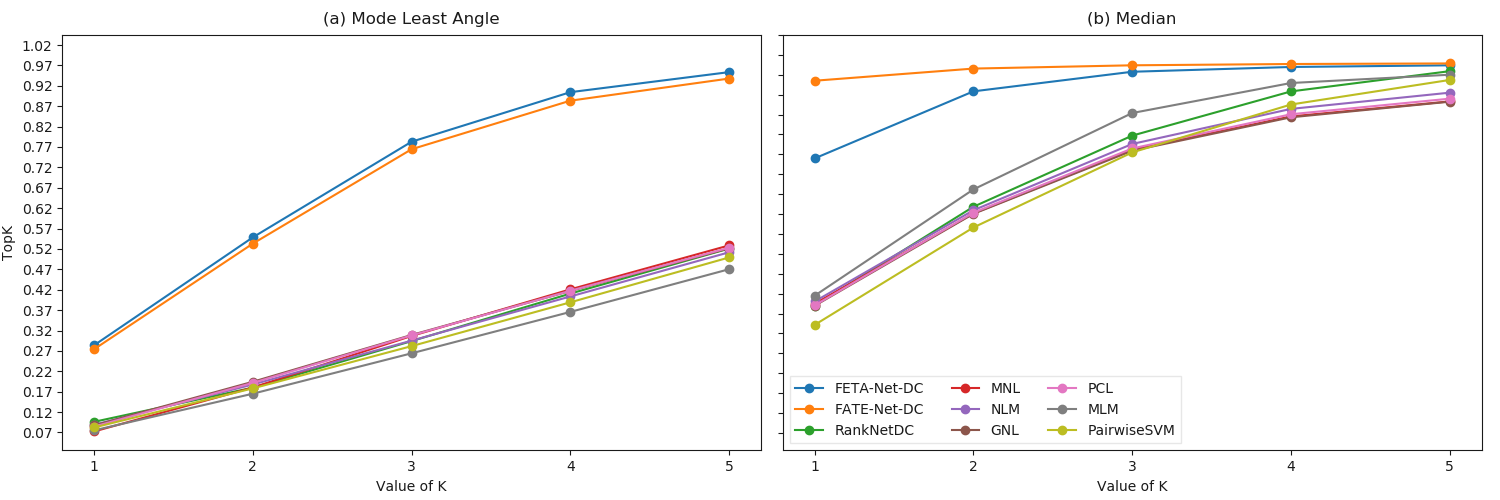

tag_genome_dc


<IPython.core.display.Javascript object>


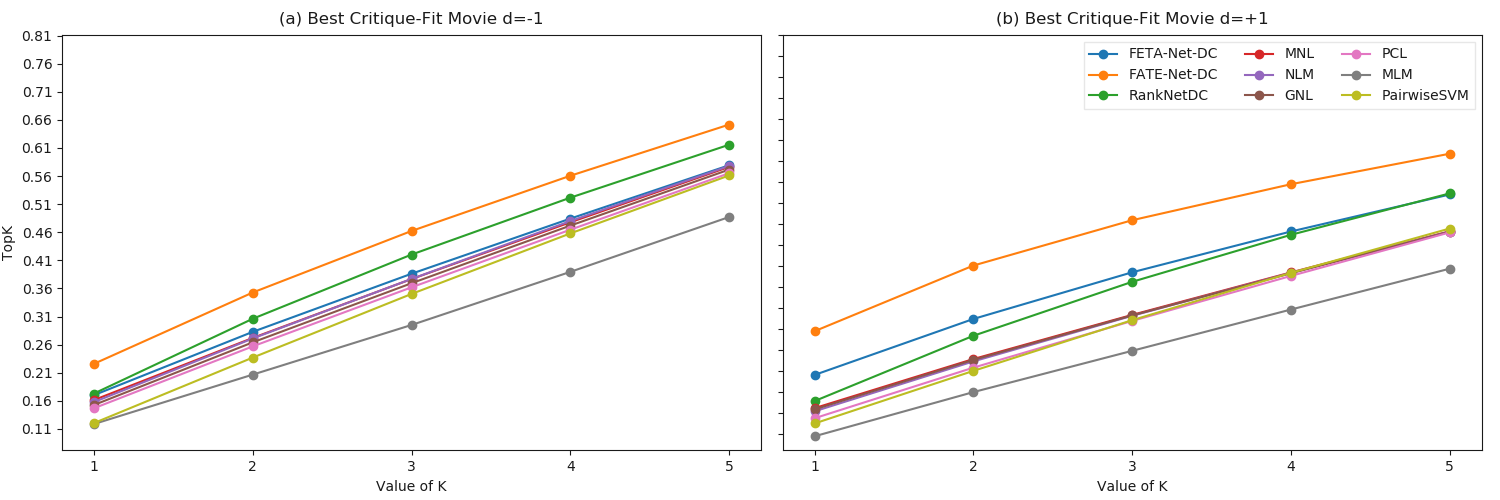

<IPython.core.display.Javascript object>


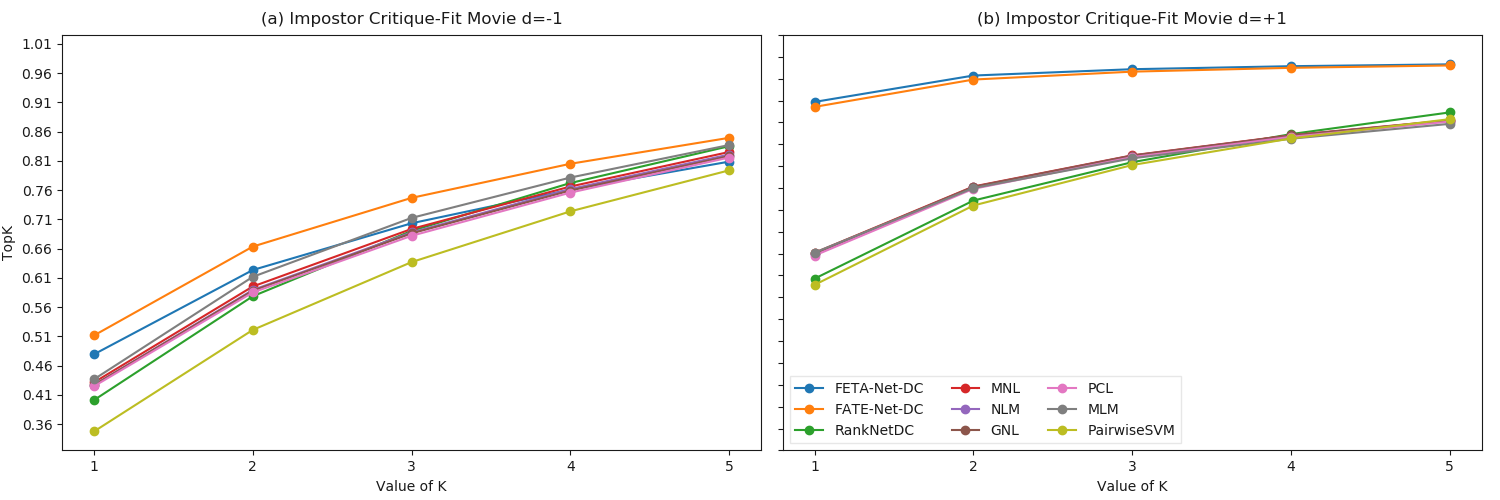

<IPython.core.display.Javascript object>


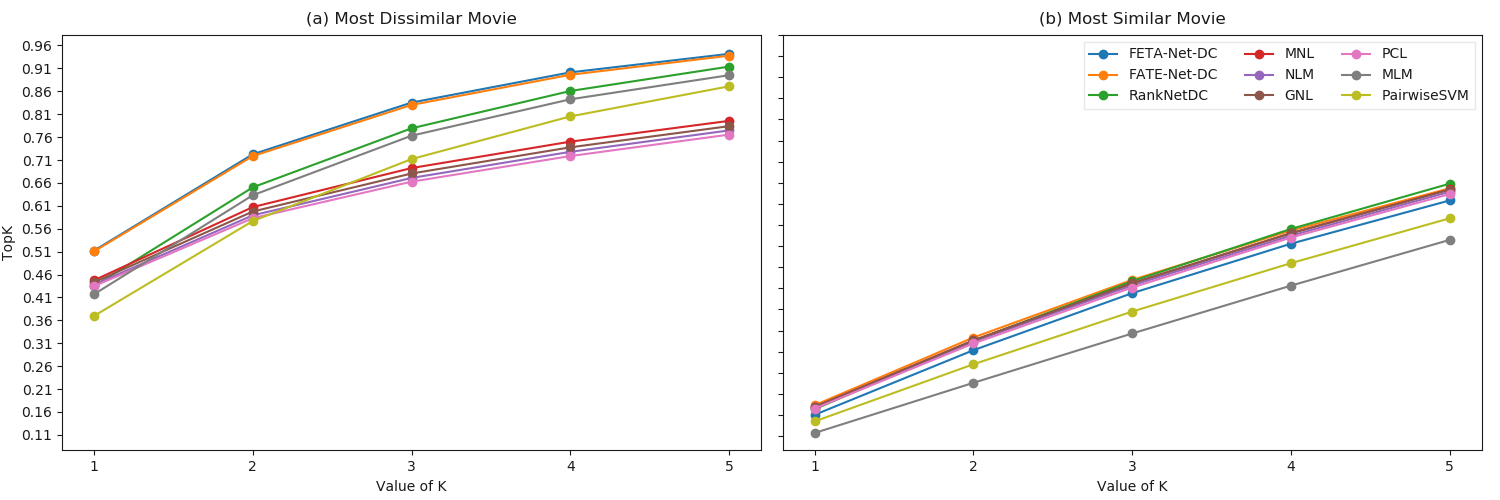

letor_dc


<IPython.core.display.Javascript object>


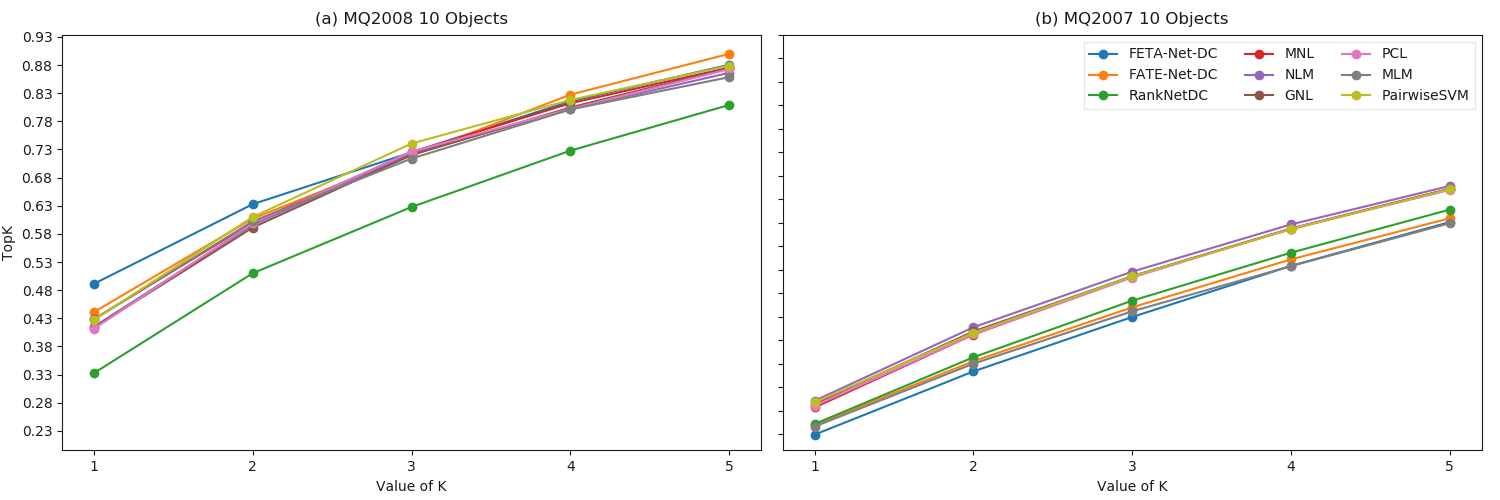

<IPython.core.display.Javascript object>


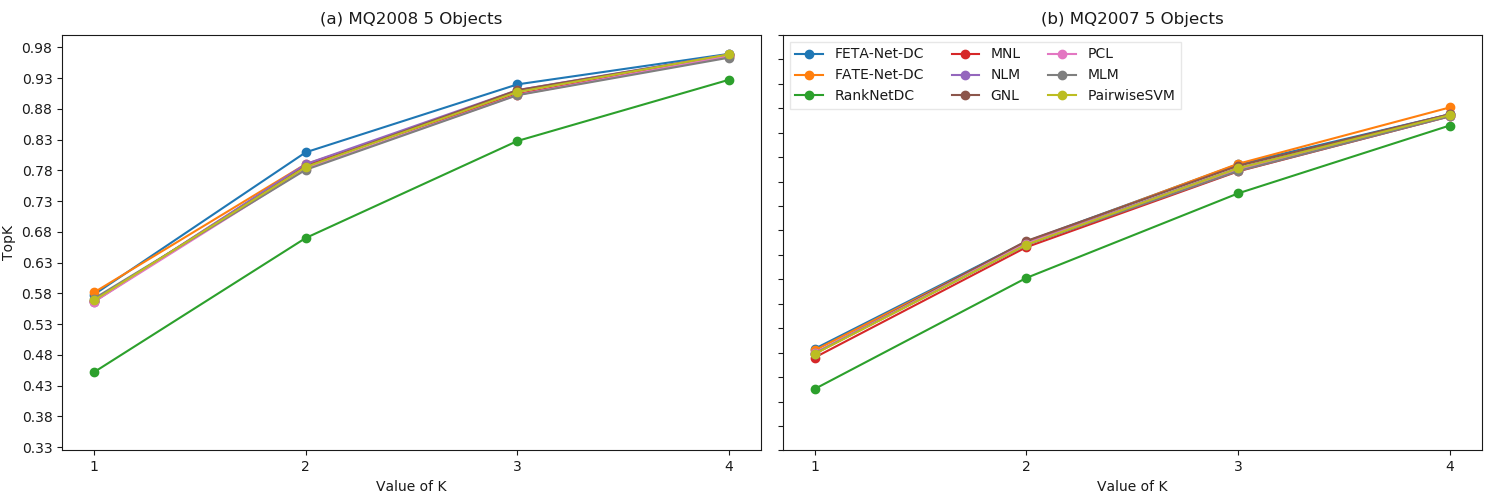

sushi_dc


<IPython.core.display.Javascript object>


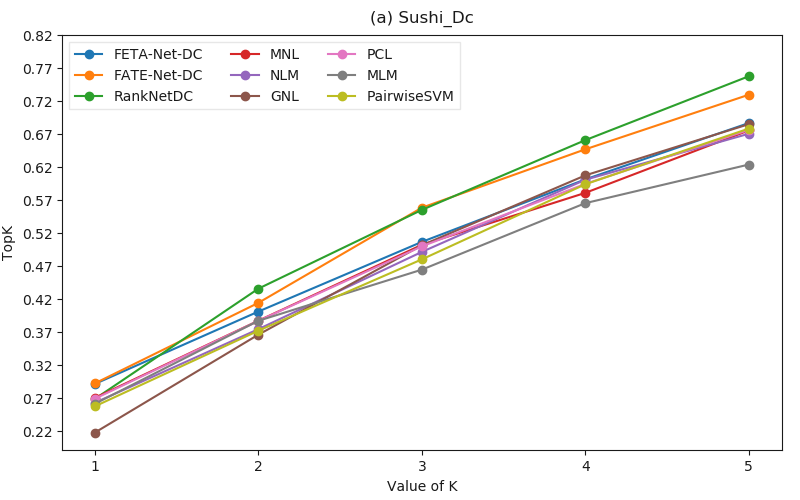

In [17]:
from constants import DCMS
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
Dlower = [d.upper() for d in DCMS]
y_label="TopK"
x_label="Value of K"
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
for dataset in datasets:
    print(dataset)
    plot_graphs_for_dataset(dataset)

In [14]:
grouped = df_full.groupby(['dataset', 'learner'])
data = []
for name, group in grouped:
    one_row = [name[0], str(name[1]).upper()]
    #latex_row = ["$ {}".format(name[0]), "$ {}".format(str(name[1]).upper())]
    std = group.std(axis=0).values
    mean = group.mean(axis=0).values
    if np.all(np.isnan(std)):
        one_row.extend(["{:.4f}".format(m) for m in mean])
        #latex_row.extend(["${:.3f}$".format(m) for m in mean]) 
    else:
        std = [s*1e3 for s in std]
        one_row.extend(["{:.3f}({:.0f})".format(m, s) for m, s in zip(mean, std)])
        #latex_row.extend(["$ {:.3f} \pm {:.3f} ".format(m, s) for m, s in zip(mean, std)])
    data.append(one_row)

In [16]:
df = pd.DataFrame(data, columns=columns)
df.sort_values(by='dataset')
df_path = os.path.join(DIR_PATH, 'results' , DATASET+'.csv')
df.to_csv(df_path)
df

,dataset,learner,categoricalaccuracy,categoricaltopk2,categoricaltopk3,categoricaltopk4,categoricaltopk5,categoricaltopk6
0,SUSHI_DC,FATE_DC,0.292(21),0.414(18),0.559(78),0.647(45),0.730(35),0.808(11)
1,SUSHI_DC,FETA_DC_SHALLOW,0.292(7),0.401(23),0.507(26),0.602(40),0.687(32),0.769(35)
2,SUSHI_DC,FETA_DC_SHALLOW_ZERO,0.237(27),0.359(33),0.484(46),0.577(41),0.681(39),0.742(24)
3,SUSHI_DC,GENERALIZED_EXTREME_VALUE,0.218(62),0.366(71),0.502(18),0.608(23),0.685(22),0.754(34)
4,SUSHI_DC,MIXED_LOGIT_MODEL,0.262(7),0.387(8),0.465(14),0.566(13),0.624(10),0.724(14)
5,SUSHI_DC,MULTINOMIAL_LOGIT_MODEL,0.271(6),0.387(5),0.502(2),0.581(18),0.676(11),0.786(7)
6,SUSHI_DC,NESTED_LOGIT_MODEL,0.263(12),0.375(5),0.492(14),0.601(11),0.671(13),0.736(24)
7,SUSHI_DC,PAIRED_COMBINATORIAL_LOGIT,0.269(6),0.387(6),0.500(12),0.595(18),0.676(10),0.785(6)
8,SUSHI_DC,RANKNET_DC_SHALLOW,0.269(13),0.436(20),0.555(25),0.661(14),0.758(21),0.831(20)
9,SUSHI_DC,RANKSVM_DC,0.258(4),0.372(7),0.480(22),0.594(17),0.679(13),0.779(6)


In [41]:
import re
def remove_ranker(sub_df):
    remove_ranker = None
    if len(sub_df)==2:
        sub_df = sub_df[:,1:3]
        val1 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[0][1])]
        val2 = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", sub_df[1][1])]
        val1 = val1[0] if len(val1)==1 else val1[0] - val1[1]*1e-3
        val2 = val2[0] if len(val2)==1 else val2[0] - val2[1]*1e-3
        if val1 < val2 :
            remove_ranker = sub_df[0][0]
        else:
            remove_ranker = sub_df[1][0]
    
    return remove_ranker

In [42]:
def get_val(val):
    vals =  [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", val)]
    return [vals[0], vals[0] - vals[1]*1e-3]
def mark_best(df):
    for col in list(df.columns)[1:]:
        values_str = df[['learner',col]].as_matrix()
        values = np.array([[val[0]] + get_val(val[1])for val in values_str])
        maxi = np.where(values[:,2] == values[:,2][np.argmax(values[:,2])])[0]
        for ind in maxi:
            values_str[ind] = [values_str[ind][0], "bfseries {}".format(values_str[ind][1])]
        df['learner'] = values_str[:,0]
        df[col] = values_str[:,1]
    return df

In [43]:
#from tabulate import tabulate
import string
grouped = df.groupby(['dataset'])
for name, group in grouped:
    
    remove_rankers = []
    sub_df = group[group['learner'].str.contains("FETA")].as_matrix()
    r1 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("FATE")].as_matrix()
    r2 = remove_ranker(sub_df)
    sub_df = group[group['learner'].str.contains("RANKNET")].as_matrix()
    r3 = remove_ranker(sub_df)
    remove_rankers.append(r1)
    remove_rankers.append(r2)
    remove_rankers.append(r3)
    group = group[~group['learner'].isin(remove_rankers)]
    group = group.replace({'FETA_DC_SHALLOW_ZERO': "FETA_DC"})
    group = group.replace({'FATE_DC_SHALLOW': "FATE_DC"})
    group = group.replace({'RANKNET_DC_SHALLOW': "RANKNET_DC"})
    custom_dict = {"RANKSVM_DC":0, "RANKNET_DC":1, 'MULTINOMIAL_LOGIT_MODEL':2, 'NESTED_LOGIT_MODEL':3, 'GENERALIZED_EXTREME_VALUE':4, 
                   'PAIRED_COMBINATORIAL_LOGIT':5, "MIXED_LOGIT_MODEL":6, "FATE_DC":7, "FETA_DC":8, "FETA_DC_ZERO":9}
    group['rank'] = group['learner'].map(custom_dict)
    group.sort_values(by='rank', inplace=True)
    del group["dataset"]
    del group['rank']
    group = mark_best(group)
    if len(group)==9:
        group['learner'] = ["pairwisesvm", "ranknetdc", "mnl", "nlm", "gnl", "pcl", "mlm", "fatedc", "fetadc"]
    print("name {}".format(name))
    group = group.drop(columns='categoricaltopk6')
    if "N_5" in name:
        group = group.drop(columns='categoricaltopk5')
    latex_code = group.to_latex(index = False)
    latex_code = latex_code.replace(' ',"")
    latex_code = latex_code.replace('&'," & ")
    latex_code = str(latex_code)
    for learner in group['learner']:
        latex_code = latex_code.replace(learner, "\\{}".format(learner))
    latex_code = latex_code.replace("bfseries", "\\{} ".format("bfseries"))
    latex_code = latex_code.replace("0.", ".")

    print(latex_code)
#df.T.to_latex()

name SUSHI_DC
\begin{tabular}{llllll}
\toprule
learner & categoricalaccuracy & categoricaltopk2 & categoricaltopk3 & categoricaltopk4 & categoricaltopk5\\
\midrule
\pairwisesvm & .258(4) & .372(7) & .480(22) & .594(17) & .679(13)\\
\ranknetdc & .269(13) & \bfseries .436(20) & \bfseries .555(25) & \bfseries .661(14) & \bfseries .758(21)\\
\mnl & .271(6) & .387(5) & .502(2) & .581(18) & .676(11)\\
\nlm & .263(12) & .375(5) & .492(14) & .601(11) & .671(13)\\
\gnl & .218(62) & .366(71) & .502(18) & .608(23) & .685(22)\\
\pcl & .269(6) & .387(6) & .500(12) & .595(18) & .676(10)\\
\mlm & .262(7) & .387(8) & .465(14) & .566(13) & .624(10)\\
\fatedc & .292(21) & .414(18) & .559(78) & .647(45) & .730(35)\\
\fetadc & \bfseries .292(7) & .401(23) & .507(26) & .602(40) & .687(32)\\
\bottomrule
\end{tabular}



In [17]:
df_path = os.path.join(DIR_PATH, 'results' , "discrete_choice.csv")

if not os.path.isfile(df_path):
    dataFrame = df
else:
    dataFrame = pd.read_csv(df_path, index_col=0)
    dataFrame = dataFrame.append(df, ignore_index=True)
dataFrame
dataFrame.to_csv(df_path)

In [30]:
grouped = df.groupby(['dataset'])
for name, group in grouped:
    df_path = os.path.join(DIR_PATH, 'results' , name.lower()+'.csv')
    group.to_csv(df_path)

In [31]:
import numpy as np
np.arange(48,87)

X_train = np.arange(40).reshape(4,5,2)

learner_params = {}
learner_params['n_objects'], learner_params['n_object_features'] = X_train.shape[1:]

In [57]:
"UNIQUE_MAX_OCCURRING".lower()

'unique_max_occurring'